In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [33]:
xs = np.linspace(-3, 3)
s = 1

G = np.exp(-xs**2 / (2*s**2)) / (np.sqrt(2*np.pi)*s)

# Constant function
G1 = np.zeros_like(xs)
G1[(xs <= s) & (xs >= -s)] = 1
G1 /= 2*s

# Traingular function
G2 = -1*np.sign(xs)*xs / (2*s) + 1
G2[(xs < -2*s) | (xs > 2*s)] = 0
G2 /= 2*s


(-0.1, 1.5)

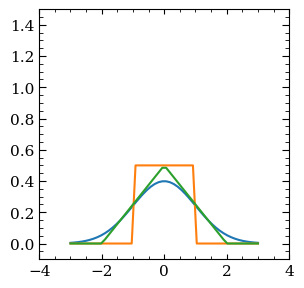

In [35]:
plt.plot(xs, G)
plt.plot(xs, G1)
plt.plot(xs, G2)

plt.xlim(-4,4)
plt.ylim(-0.1, 1.5)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
import numpy as np
sys.path.append('../')
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise
from matplotlib import pyplot as plt
from asymmetry import _sky_properties, fourier_deconvolve
from astropy.convolution import Gaussian2DKernel

In [29]:
def make_galaxy(mag, r_eff, psf_fwhm, sky_mag, n_clumps, fov_reff, pxscale, sersic_n, q, beta):
    

    perfect_img, params, rpet = simulate_perfect_galaxy(mag=mag, r_eff=r_eff, pxscale=pxscale, fov_reff=fov_reff, sersic_n=sersic_n, 
                                                    q=q,beta=beta, n_clumps=n_clumps)
    
    image_psf = add_source_to_image(**params, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method="astropy")
    image_noise, noise = sky_noise(image_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)
    return perfect_img, image_noise, rpet


In [31]:
image_perfect, image_noisy, r_pet = make_galaxy(15, 5, 1.0, 22, 0, 21.05, 0.3, 1, 1, 0)
bgsize = int(0.1*image_noisy.shape[0]) # 10% of the image
sky_a, sky_norm, sky_std = _sky_properties(image_noisy, bgsize, a_type='squared')

psf_fwhm = 1.0
psf_sigma = psf_fwhm  / 0.3
psf = Gaussian2DKernel(psf_sigma, x_size=image_noisy.shape[1], y_size=image_noisy.shape[0])
tmp = fourier_deconvolve(image_noisy, psf, sky_std)

In [15]:
arr = np.random.randint(0, 10, (5,5))
xc = int(arr.shape[0]/2)
arr_corner = arr[:xc, :xc]
arr

array([[4, 8, 0, 7, 5],
       [7, 1, 4, 8, 8],
       [3, 3, 1, 8, 5],
       [4, 9, 4, 5, 5],
       [2, 1, 4, 1, 7]])

In [24]:
arr[0, -1::-1]

array([5, 7, 0, 8, 4])

In [45]:
fit_snr = np.ones_like(arr)
fit_snr[:xc,:xc] = arr_corner[:-1,:-1]
fit_snr[xc:,:xc] = arr_corner[::-1,:-1]
fit_snr[:xc,xc:] = arr_corner[:-1,::-1]
fit_snr[xc:,xc:] = arr_corner[::-1, ::-1]

ValueError: could not broadcast input array from shape (2,1) into shape (3,2)

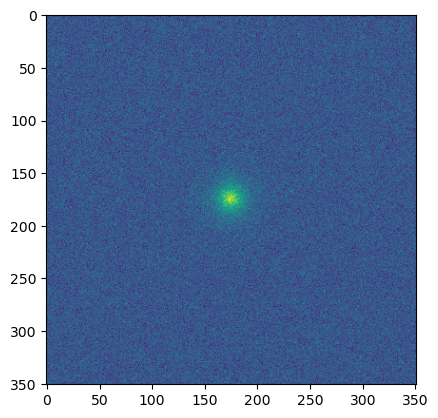

In [32]:
plt.imshow(tmp)